# DINO with memory brank from Hummingbird (inference only)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d residentmario/ade20k-outdoors

 98% 197M/200M [00:02<00:00, 106MB/s]
100% 200M/200M [00:02<00:00, 90.7MB/s]


In [ ]:
!unzip -q /content/ade20k-outdoors.zip

In [ ]:
!pip install transformers
!pip install datasets
!pip install tqdm
!pip install scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 47.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled k

In [ ]:
import torch
import scann
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import random_split

torch.manual_seed(10)

# Preprocessing

In [ ]:
from transformers import ViTImageProcessor, ViTModel
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)




    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        image = image.permute(1, 2, 0)

        return image, np.array(mask)
# Define a custom transform function
def clamp_image(img):
    return torch.clamp(img, 0, 1)

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255],
    clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No clamping for masks
])

dataset = SegmentationDataset(image_dir='/content/images/training', mask_dir='/content/annotations/training', image_transform=image_transform, mask_transform=mask_transform)

In [ ]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# # Define the size of the subset
# subset_size = 10000

# # Create a subset of the original dataset
# subset_indices = torch.randperm(len(train_dataset))[:subset_size]
# subset = Subset(train_dataset, subset_indices)

# # Create a DataLoader from this subset
# subset_loader = DataLoader(subset, batch_size=4, shuffle=True)

In [ ]:
subset_size = 10

# Create a subset of the original dataset
subset_indices = torch.randperm(len(test_dataset))[:subset_size]
subset = Subset(test_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader_test = DataLoader(subset, batch_size=1, shuffle=False)

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    image, mask = train_dataset[i]

    ax[i, 0].imshow(image.numpy())
    ax[i, 1].imshow(mask, cmap='gray')

    ax[i, 0].set_title('Image')
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Assume `segmentation_map` is a numpy array of shape (224, 224) with semantic segmentation labels
# Each unique value in the segmentation_map represents a different class

# Function to divide the image into patches and average the labels within each patch
def average_labels(segmentation_map, patch_size=(16, 16)):
    # Get the shape of the segmentation map
    batch_size,h,w = segmentation_map.shape
    # Calculate the number of patches along each dimension
    h_patches = h // patch_size[0]
    w_patches = w // patch_size[1]

    batch_patch_labels = []
    # Loop over each image in the batch
    for b in range(batch_size):
        # Initialize a list to hold the average label for each patch for the current image
        patch_labels = []

        # Loop over the segmentation map and compute the average label for each patch
        for i in range(h_patches):
            for j in range(w_patches):
                # Define the patch boundaries
                start_i = i * patch_size[0]
                start_j = j * patch_size[1]
                end_i = start_i + patch_size[0]
                end_j = start_j + patch_size[1]

                # Extract the patch
                patch = segmentation_map[b, start_i:end_i, start_j:end_j].to(torch.float16)


                # Compute the most frequent label (mode) within the patch
                # labels, counts = np.unique(patch, return_counts=True)
                # most_frequent_label = labels[np.argmax(counts)]

                #Compute the mean label within the patch
                average_label = torch.mean(patch)
                # average_label = np.round(average_label).to(torch.uint8)
                patch_labels.append(average_label)

        # Append the list of patch labels for the current image to the batch list

        batch_patch_labels.append(patch_labels)
    return np.array(batch_patch_labels)



# Populating memory bank

In [ ]:
memory_bank = []
model = model.to(device)
# Process each image in the image list
for image, label in tqdm(train_loader, desc="Populate memory bank"):
    # Process the image and label
    local_labels = average_labels(label)
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state


    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[:,1:, :]

    # L2-normalize the feature vector
    patch_features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    for i in range(patch_features.size(0)):  # Iterate over batch
        # Get the features and labels for the i-th item in the batch
        patch_features = patch_features.cpu()
        features = patch_features[i]
        local_label = local_labels[i]

        # Extend the memory bank with the features and labels
        # Here we convert them to CPU tensors and detach from the graph
        memory_bank.append((features.detach(), local_label))

Populate memory bank: 100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


In [ ]:
keys = np.array([tup[0].numpy() for tup in memory_bank]) # (number of samples * number of patches) * dim size
labels = np.array([tup[1] for tup in memory_bank])

keys = keys.reshape(-1,keys.shape[2])
labels = labels.reshape(-1)

In [ ]:
del model
del processor
del inputs
del memory_bank
torch.cuda.empty_cache()
import gc
# Run garbage collection
gc.collect()

2970

In [ ]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Retrieving from memory bank and prediction

In [ ]:
searcher = scann.scann_ops_pybind.builder(keys, 50, "dot_product").tree(
    num_leaves=512, num_leaves_to_search=256, training_sample_size=250000).score_ah(
    4, anisotropic_quantization_threshold=0.2).reorder(1800).build()

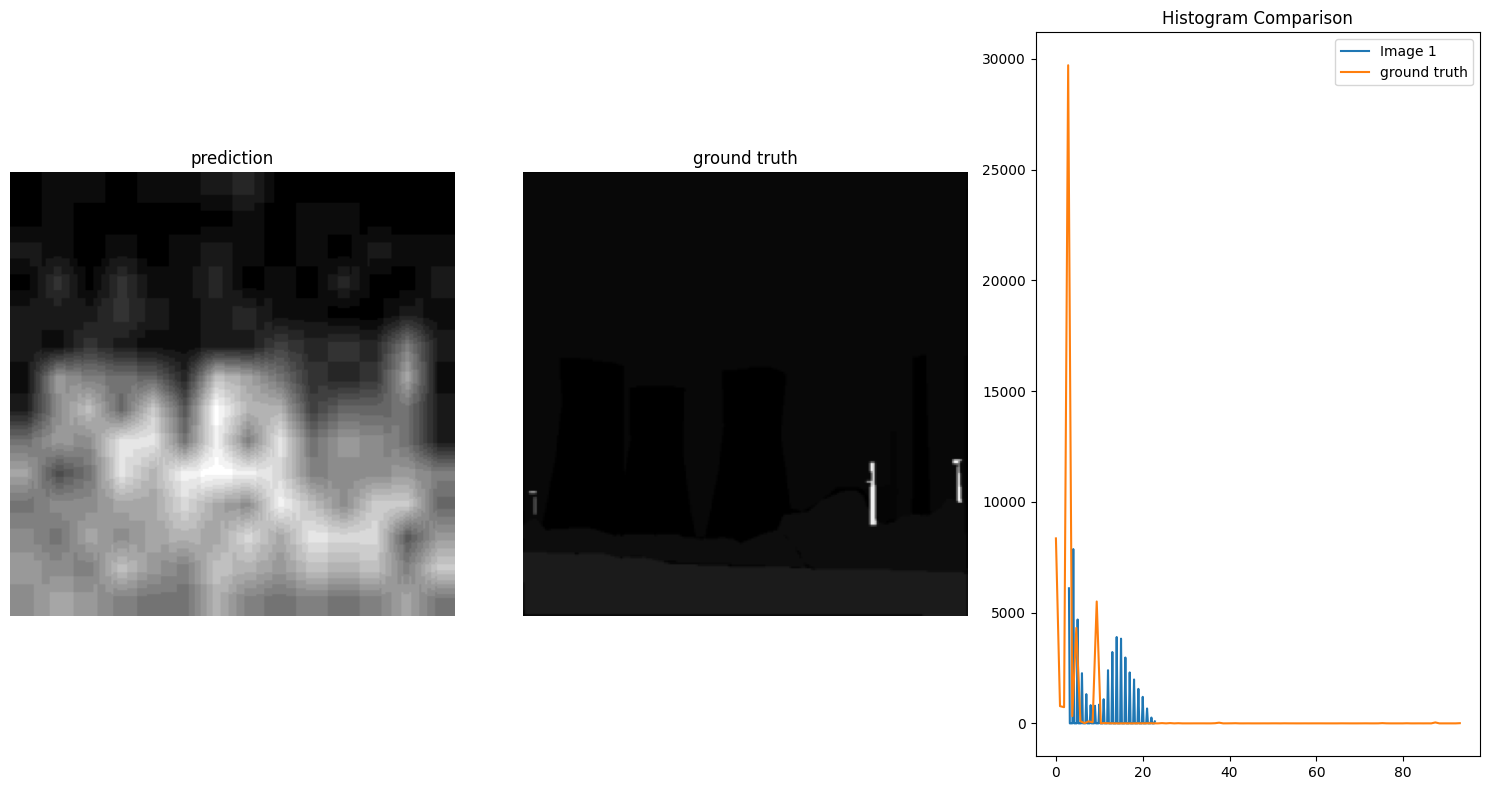

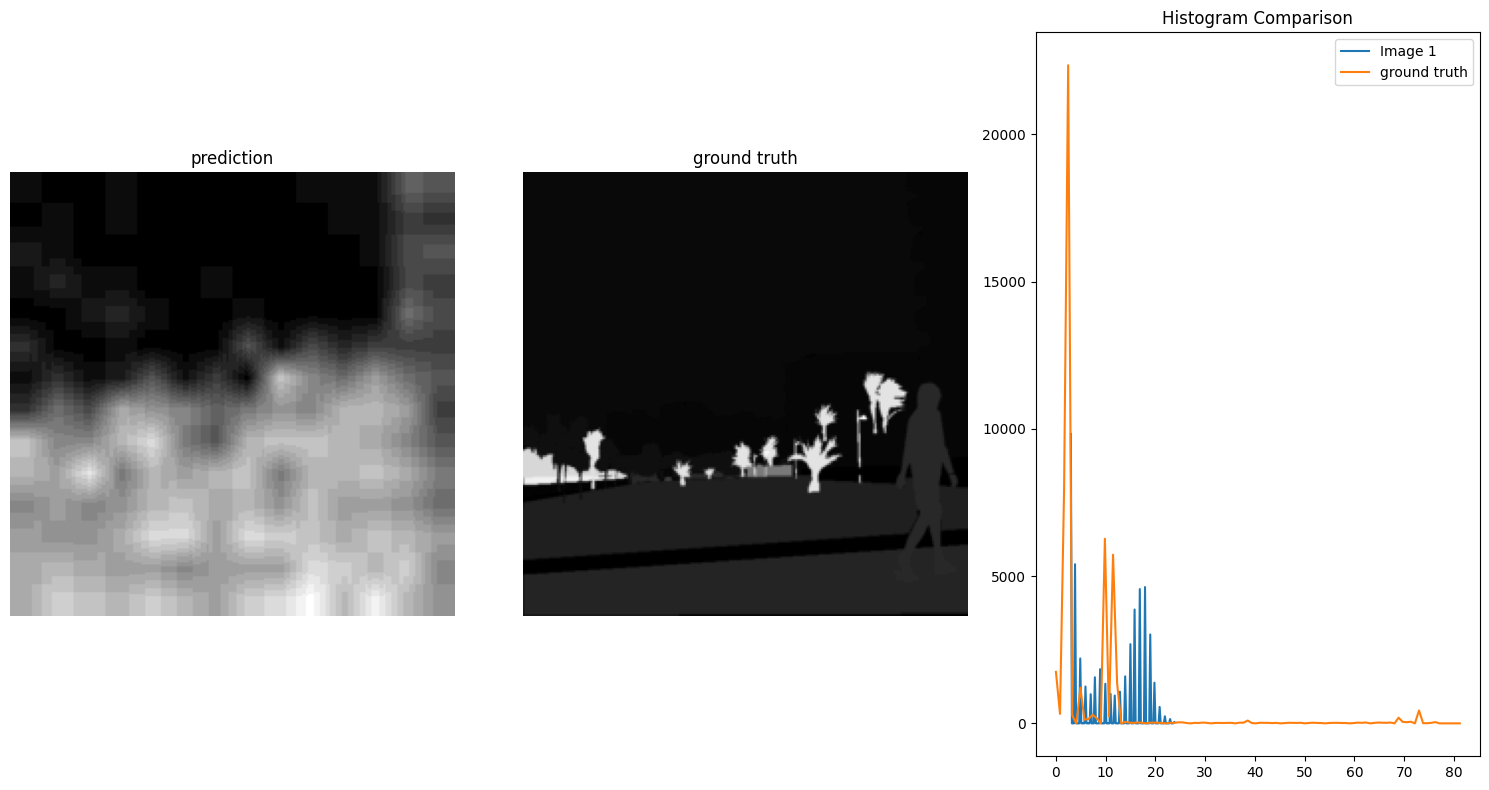

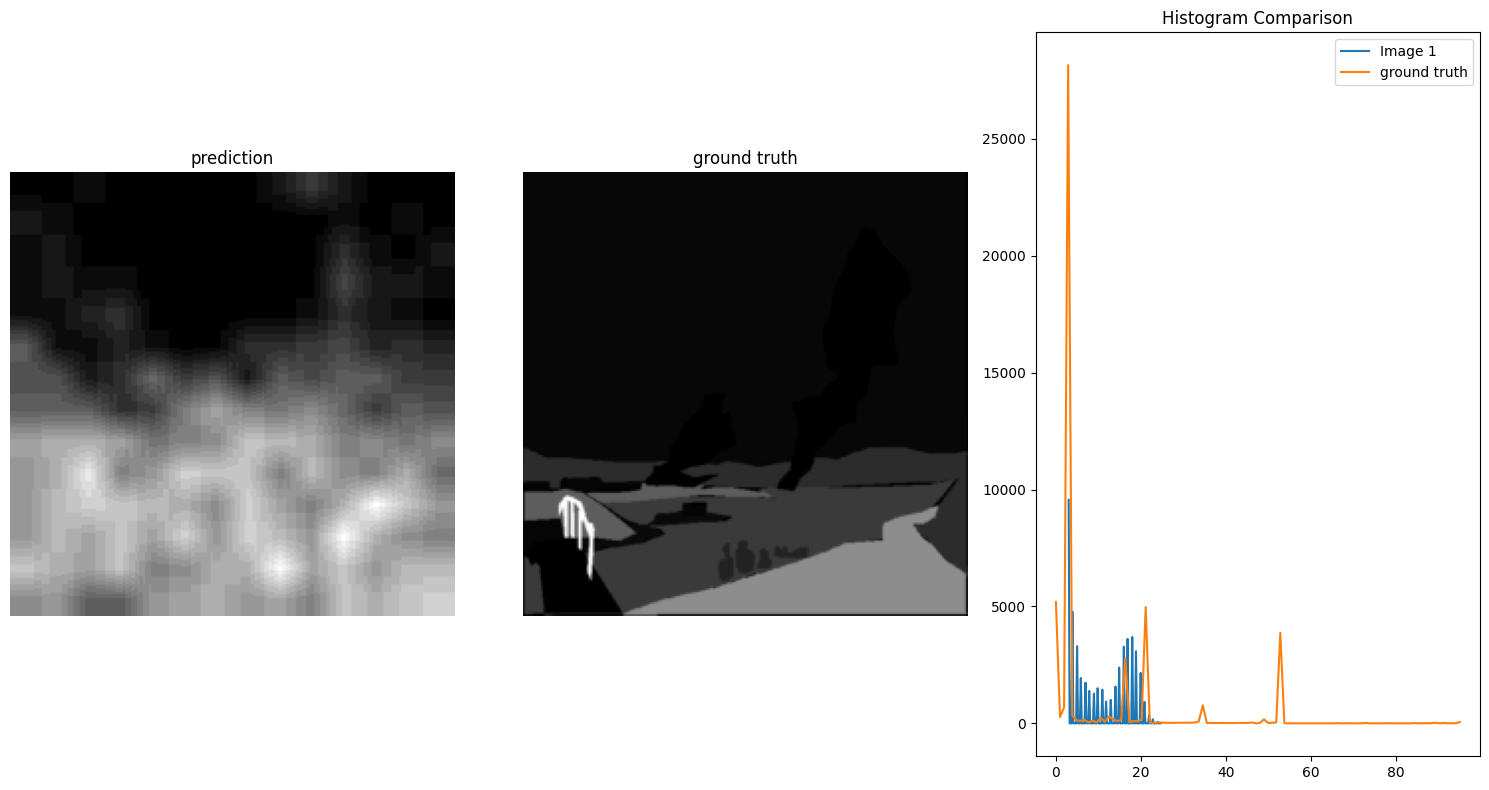

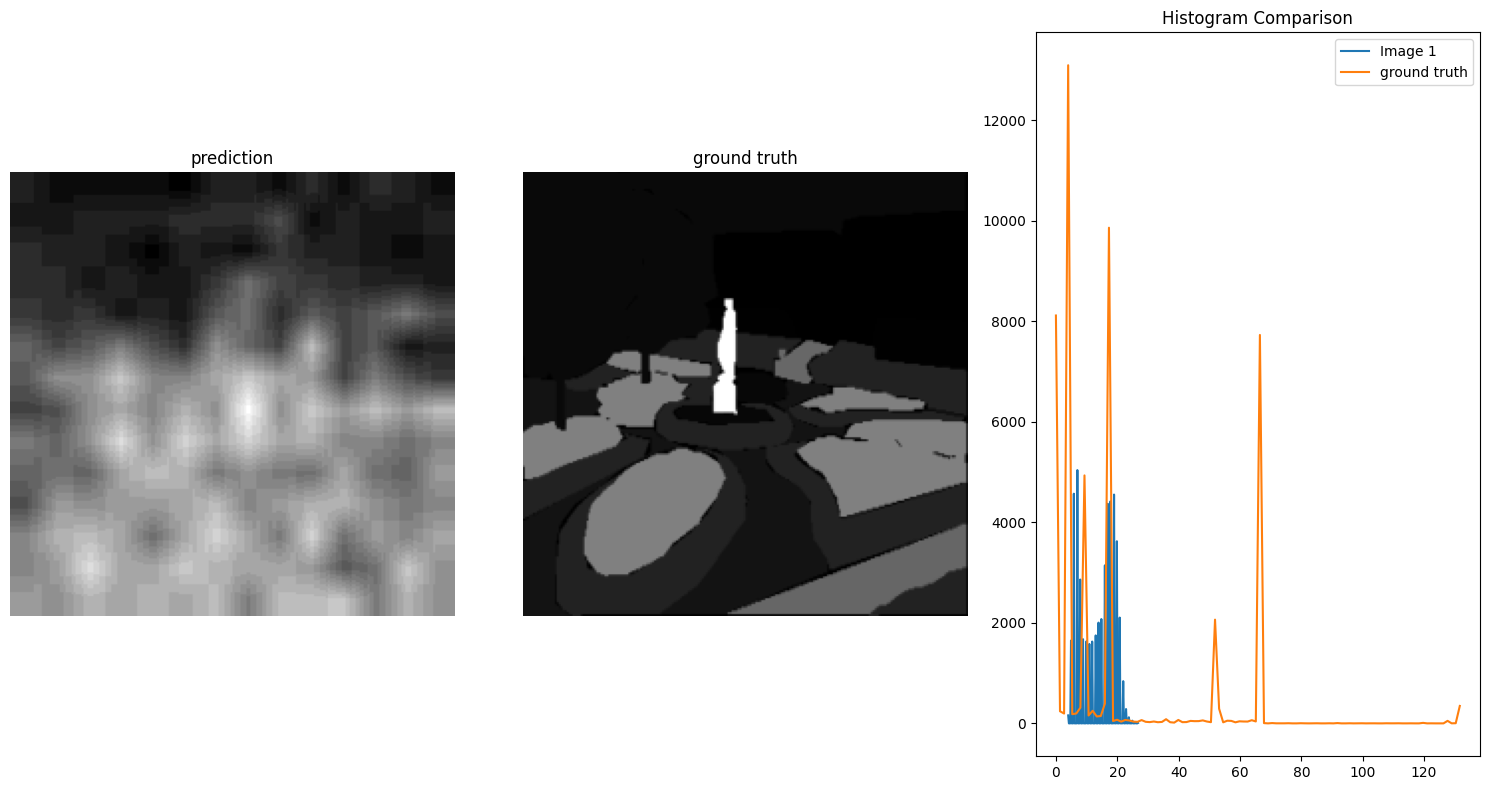

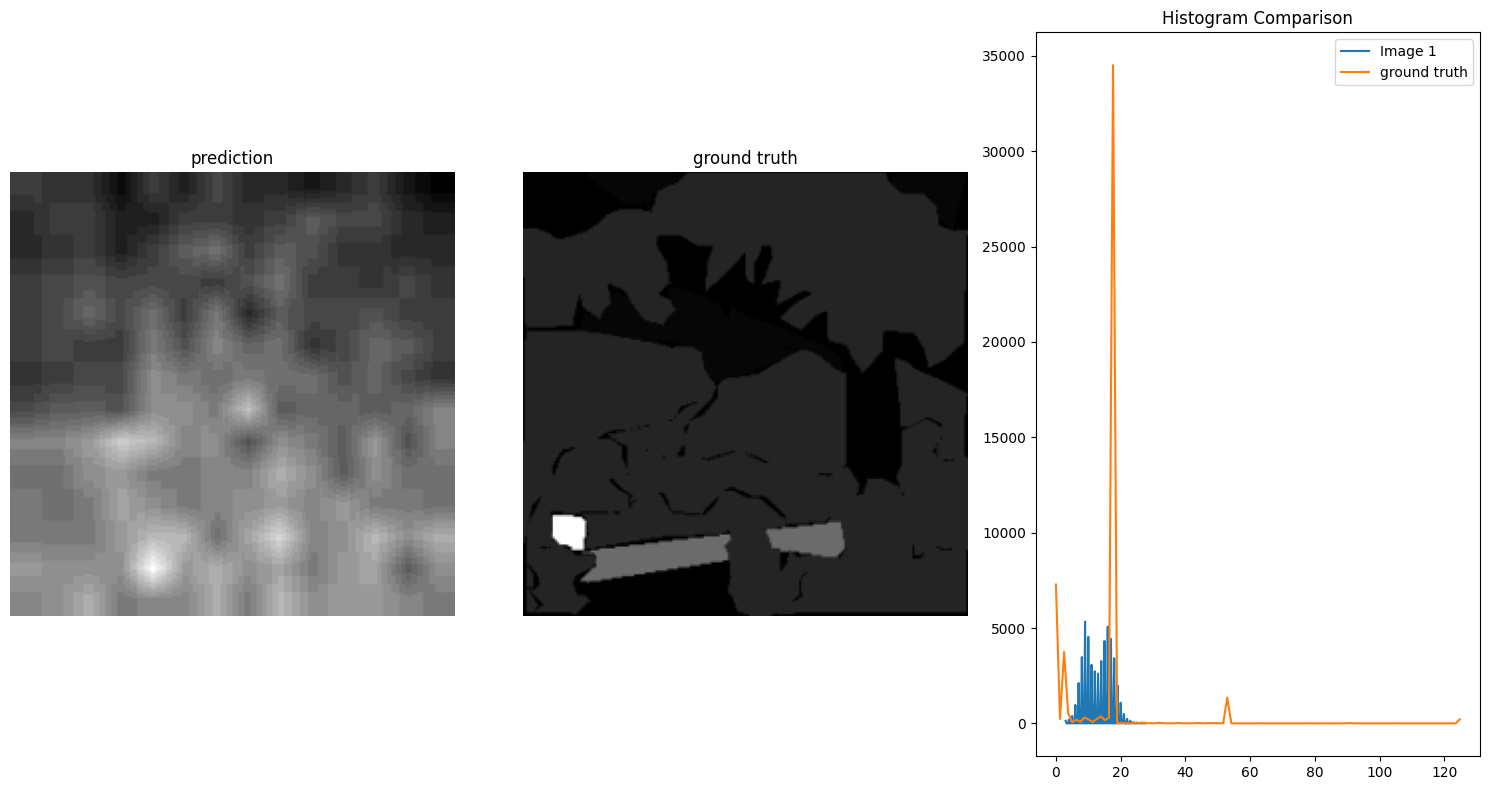

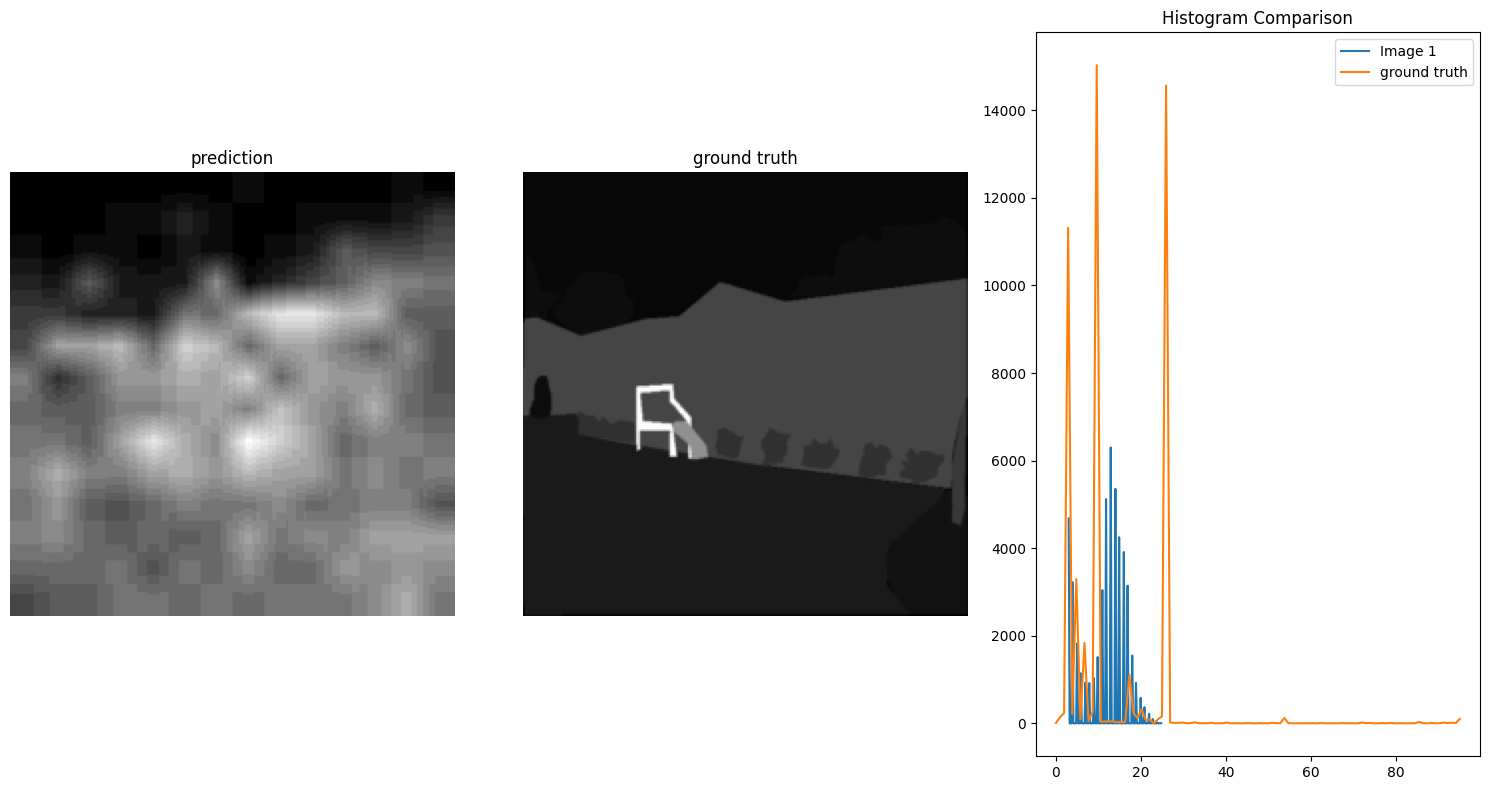

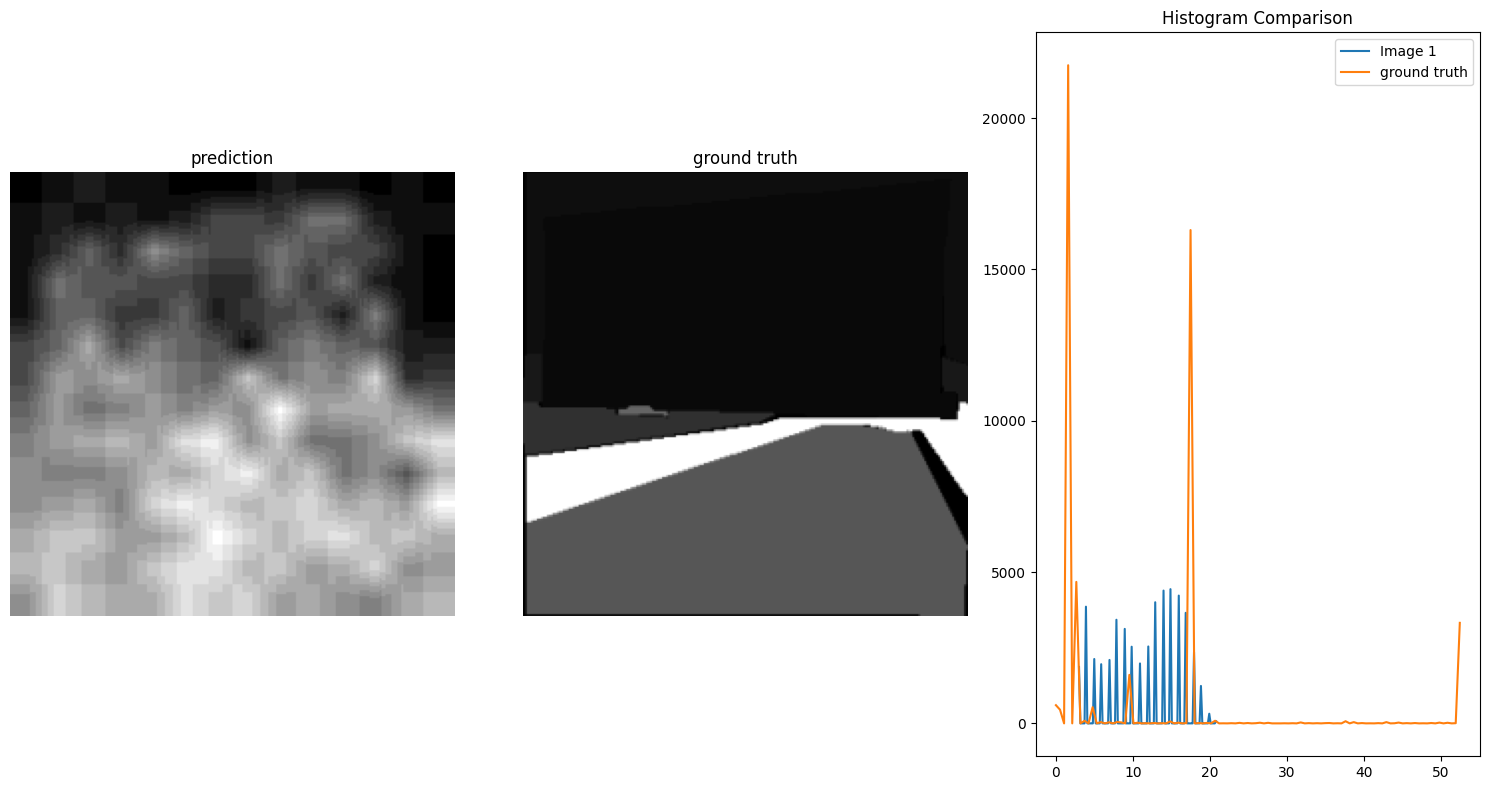

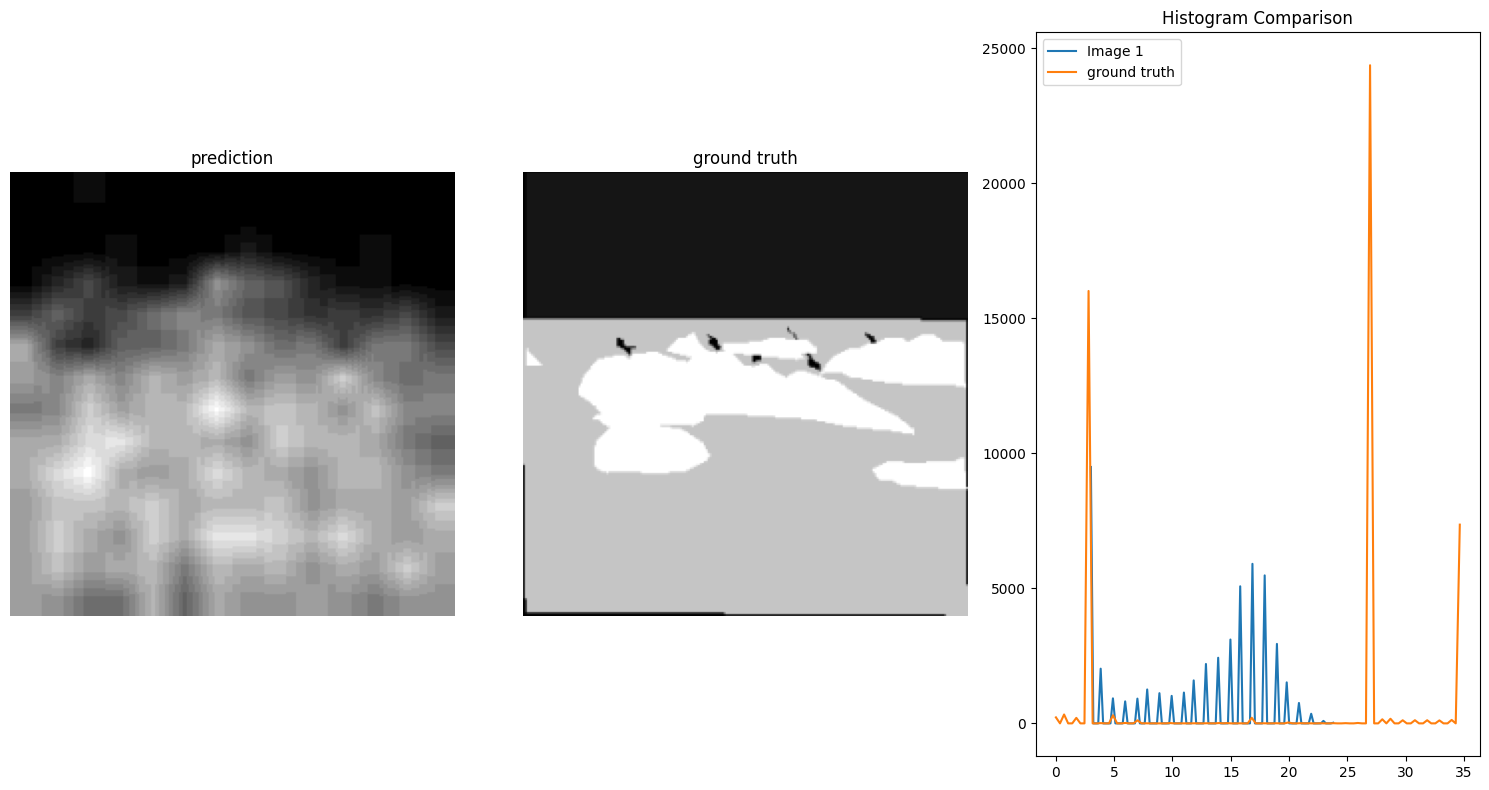

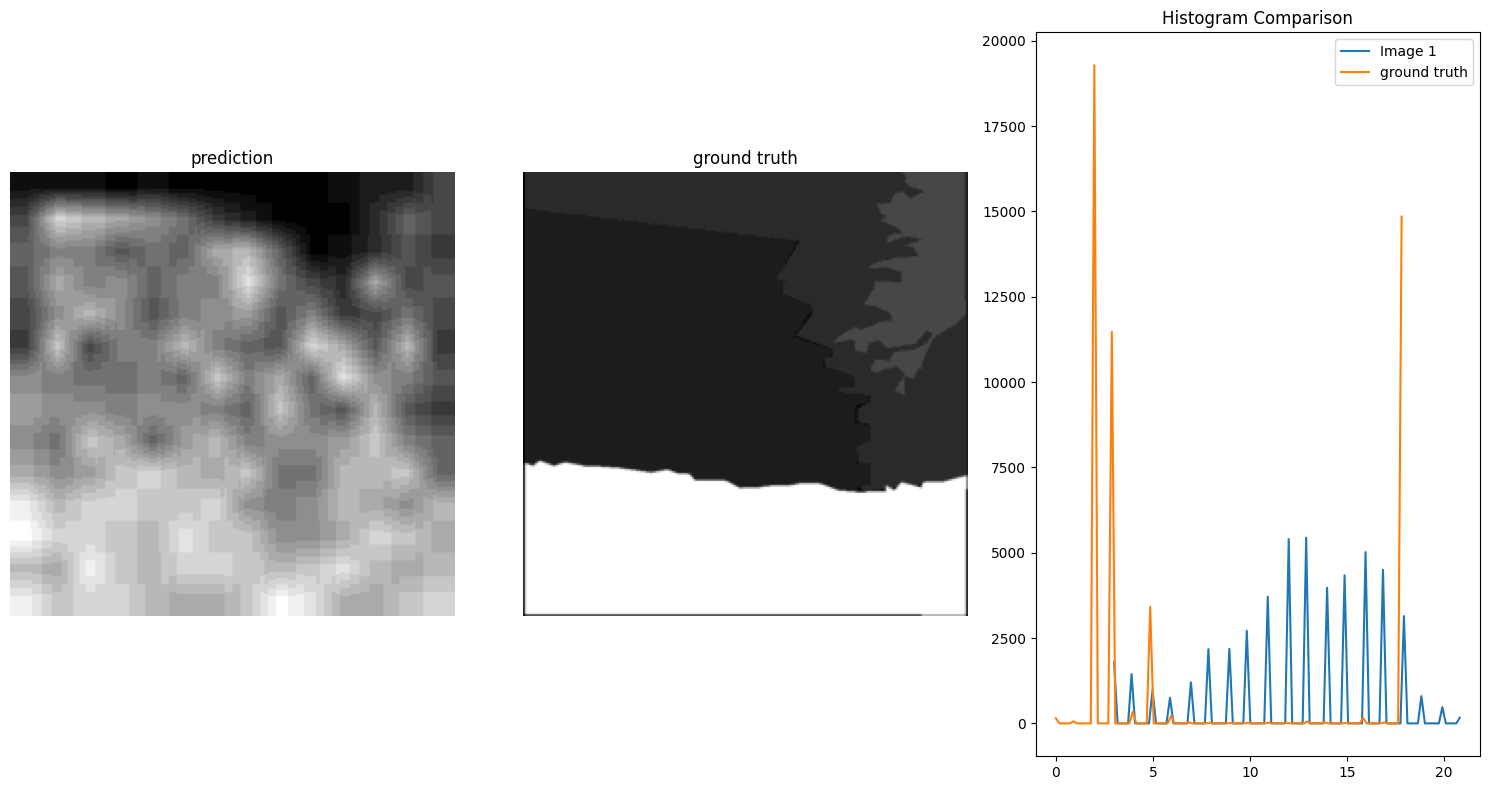

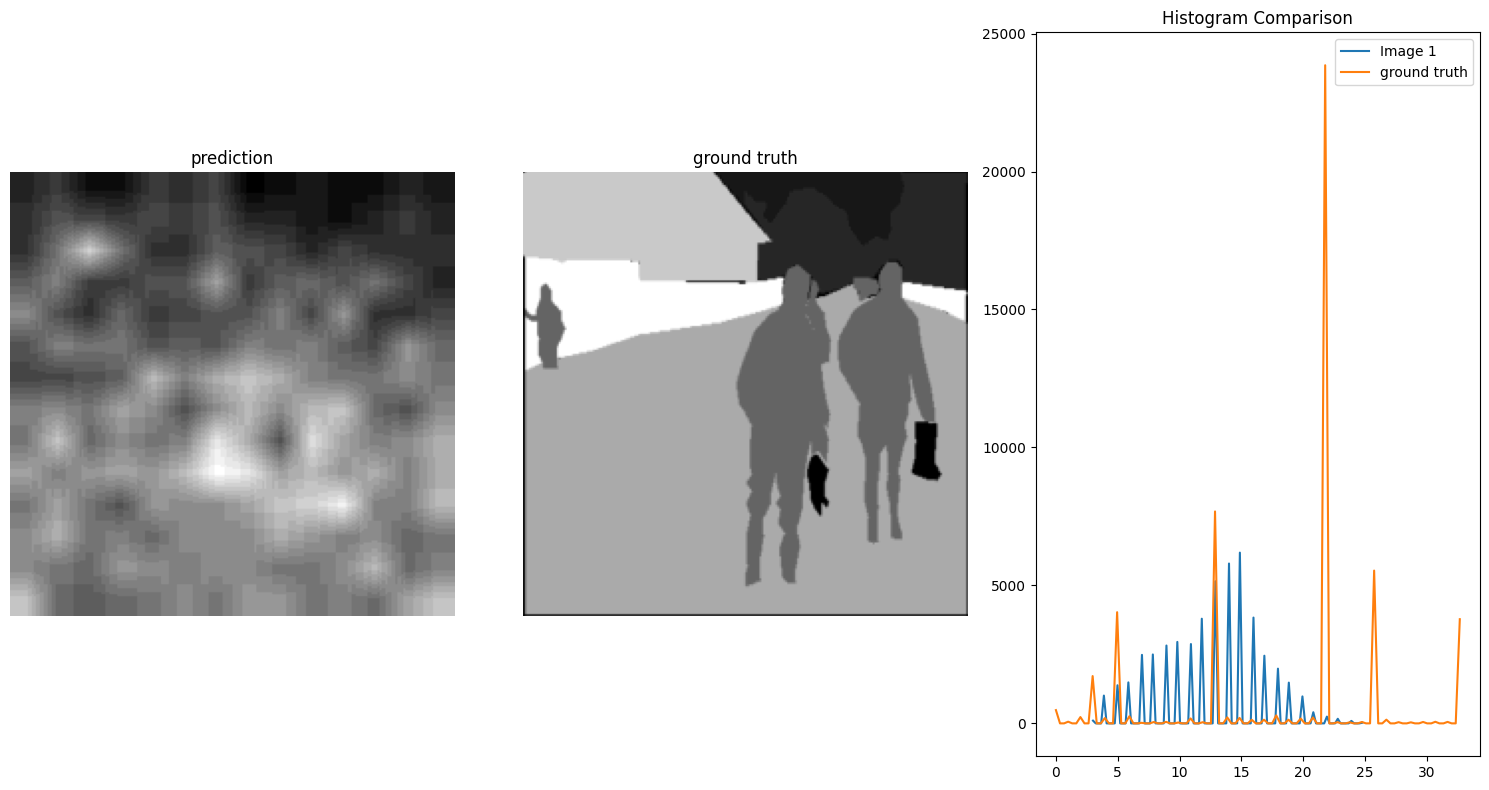

In [ ]:
beta = .1

for image, label in subset_loader_test:
    # Process the image and label
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    model.to(device)
    model.eval()
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #Squeeze the batch dimension out
    last_hidden_states = last_hidden_states.squeeze(0)
    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[1:, :]
    #patch features [784 x 768] keys
    patch_features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    # Perform the search. This will return the indices of the top-k nearest neighbors.
    neighbors, similarity = searcher.search_batched(patch_features.cpu().detach())

    similarity = (1/beta)*similarity
    similarity = torch.tensor(similarity)
    similarity  = F.softmax(similarity, dim=1)


    neighbor_labels = labels[neighbors]

    weighted_labels = similarity * neighbor_labels.astype(np.float32)
    local_predictions = torch.sum(weighted_labels, dim=1)

    local_predictions_reshaped = local_predictions.reshape((14,14))

    local_predictions_reshaped = torch.round(local_predictions_reshaped).to(torch.uint8)
    local_predictions_reshaped = local_predictions_reshaped.unsqueeze(0).unsqueeze(0)
    # Upsample the downsampled predictions to the original image size
    local_predictions_reshaped = F.interpolate(local_predictions_reshaped, size=(224, 224), mode='bilinear', align_corners=False)
    pred = np.array(local_predictions_reshaped.squeeze())

    hist1, bins1 = np.histogram(pred.flatten(), bins=100)
    hist2, bins2 = np.histogram(label.flatten(), bins=100)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    # Display images

    axes[0].imshow(pred, cmap='gray')
    axes[0].set_title('prediction')
    axes[0].axis('off')

    axes[1].imshow(np.array(label.squeeze()), cmap='gray')
    axes[1].set_title('ground truth')
    axes[1].axis('off')

    # Display histograms
    axes[2].plot(bins1[:-1], hist1, label='Image 1')
    axes[2].plot(bins2[:-1], hist2, label='ground truth')
    axes[2].set_title('Histogram Comparison')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# ISSUES

Problems I am seeing currently is that averaging the labels in patch for the memory bank, results in blurry and very uniform looking masks. This is likely due to the fact that all labels are averages per patch so the retrieval system also is only able to get average label values resulting in mostly grey segmentation maps.

If I change the average label to most frequent label (in the patch), but this is not what the authors mentioned. I am getting very erratic and chaotic segmentation maps. With sometimes a patch containing a vastly different label compared to the neighbours and shapes (or coherent regions of similar labels) are non-existent.

- This is either a result of incorrect implementation of the attention mechanism,
- or because the limited prompt images used (4000 images in similar domain).
- Additionally, it could be the scaNN setup, but I use the same settings as the original authors.

The shapes of the segmentation maps however do match the ground truth. Especially background label (for things like sky), this could indicate that the nearest neighbour search for those features seem to work as expected.

Also the attention mechanism seems weird for semantic segmentations? Imagine we find top k neighbours, meaning most similar in features to the query patch according to the DINO encoding. We take their corresponding (average) labels (local label) and we weight these according to how similar the key patch is. If the patch features are very similar to query this local label will weigh more heavily. But since we are taking like the top 90 similar patches and their labels. And we weight these labels according to similarity and then sum over all these weighted labels to get the final prediction label, it seems to be unintuitive way of predicting the label. Imagine the we only look at top 2 neighbours. We find that the patches that are most similar have labels 10 and 100. We find that they are roughly equally similar so we weight both their values by 0.5, then we sum. We will get a prediction label of 5+50 = 55. Which seems to be an awful prediction? It also depends on whether the labels are ordered in such a way that labels that are numerically close to each other are similar which can't be assumed or expected. What if a chair has label 2 and a table label 230. We can not just take the "average" of these labels.
Even if we normalise the mask, so that all labels are between 0 and 1 (which happens when we pass it through the dataloader automatically), now the labels correspond to literal pixel values (as mentioned in the paper), it still feels weird. What am I missing?


# TODO

- ~Try to do depth estimation~
- Improve performance on ADE20k subset... and overall
- Maybe try with local label distributions instead of just one label? Average label seems to make no sense to me...

In [ ]:
!kaggle datasets download -d soumikrakshit/nyu-depth-v2

100% 4.10G/4.10G [01:03<00:00, 46.0MB/s]
100% 4.10G/4.10G [01:03<00:00, 69.1MB/s]


In [ ]:
!unzip -q /content/nyu-depth-v2.zip

In [ ]:
import pandas as pd

import os
from PIL import Image
from torch.utils.data import Dataset

class NYUDepthV2Dataset(Dataset):
    def __init__(self, root_dir, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Root directory with all the subdirectories of images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_pairs = self._get_image_pairs()

    def _get_image_pairs(self):
        pairs = []
        for subdir, _, files in os.walk(self.root_dir):
            images = {}
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    number = os.path.splitext(file)[0]
                    images.setdefault(number, []).append(file)

            for number, file_list in images.items():
                if len(file_list) == 2:
                    color_image = [f for f in file_list if f.endswith('.jpg')]
                    depth_image = [f for f in file_list if f.endswith('.png')]
                    if color_image and depth_image:
                        pairs.append((os.path.join(subdir, color_image[0]), os.path.join(subdir, depth_image[0])))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        color_path, depth_path = self.image_pairs[idx]

        color_image = Image.open(color_path)
        depth_image = Image.open(depth_path)

        if self.image_transform:
            color_image = self.image_transform(color_image)
        if self.mask_transform:
            depth_image = self.mask_transform(depth_image)
        color_image = color_image.permute(1, 2, 0)
        depth_image = depth_image.permute(1, 2, 0)
        return color_image, depth_image


# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No clamping for masks
    transforms.ToTensor(),
])

# Example usage
train_dataset = NYUDepthV2Dataset( root_dir='/content/nyu_data/data/nyu2_train', image_transform=image_transform, mask_transform=mask_transform)



In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class NYUDepthV2Dataset_test(Dataset):
    def __init__(self, root_dir, csv_file, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(csv_file)
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        # Assuming you know the total number of images or can calculate it
        # Replace 10000 with the actual number of images you have
        return len(self.dataframe)

    def __getitem__(self, idx):
        idx= idx.item()
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        depth_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1])

        image = Image.open(img_name)
        mask = Image.open(depth_name)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        image = image.permute(1, 2, 0)
        mask = mask.permute(1, 2, 0)
        return image, mask

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No clamping for masks
    transforms.ToTensor(),
])
test_dataset = NYUDepthV2Dataset_test(root_dir='/content/nyu_data/', csv_file = "/content/nyu_data/data/nyu2_test.csv", image_transform = image_transform, mask_transform = mask_transform)


In [ ]:
# Define the size of the subset
subset_size_train = 4000

# Create a subset of the original dataset
subset_indices = torch.randperm(len(train_dataset))[:subset_size_train]
subset_train = Subset(train_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader_train = DataLoader(subset_train, batch_size=4, shuffle=True)

subset_size_test = 10

# Create a subset of the original dataset
subset_indices = torch.randperm(len(test_dataset))[:subset_size_test]
subset_test = Subset(test_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader_test = DataLoader(subset_test, batch_size=1, shuffle=False)

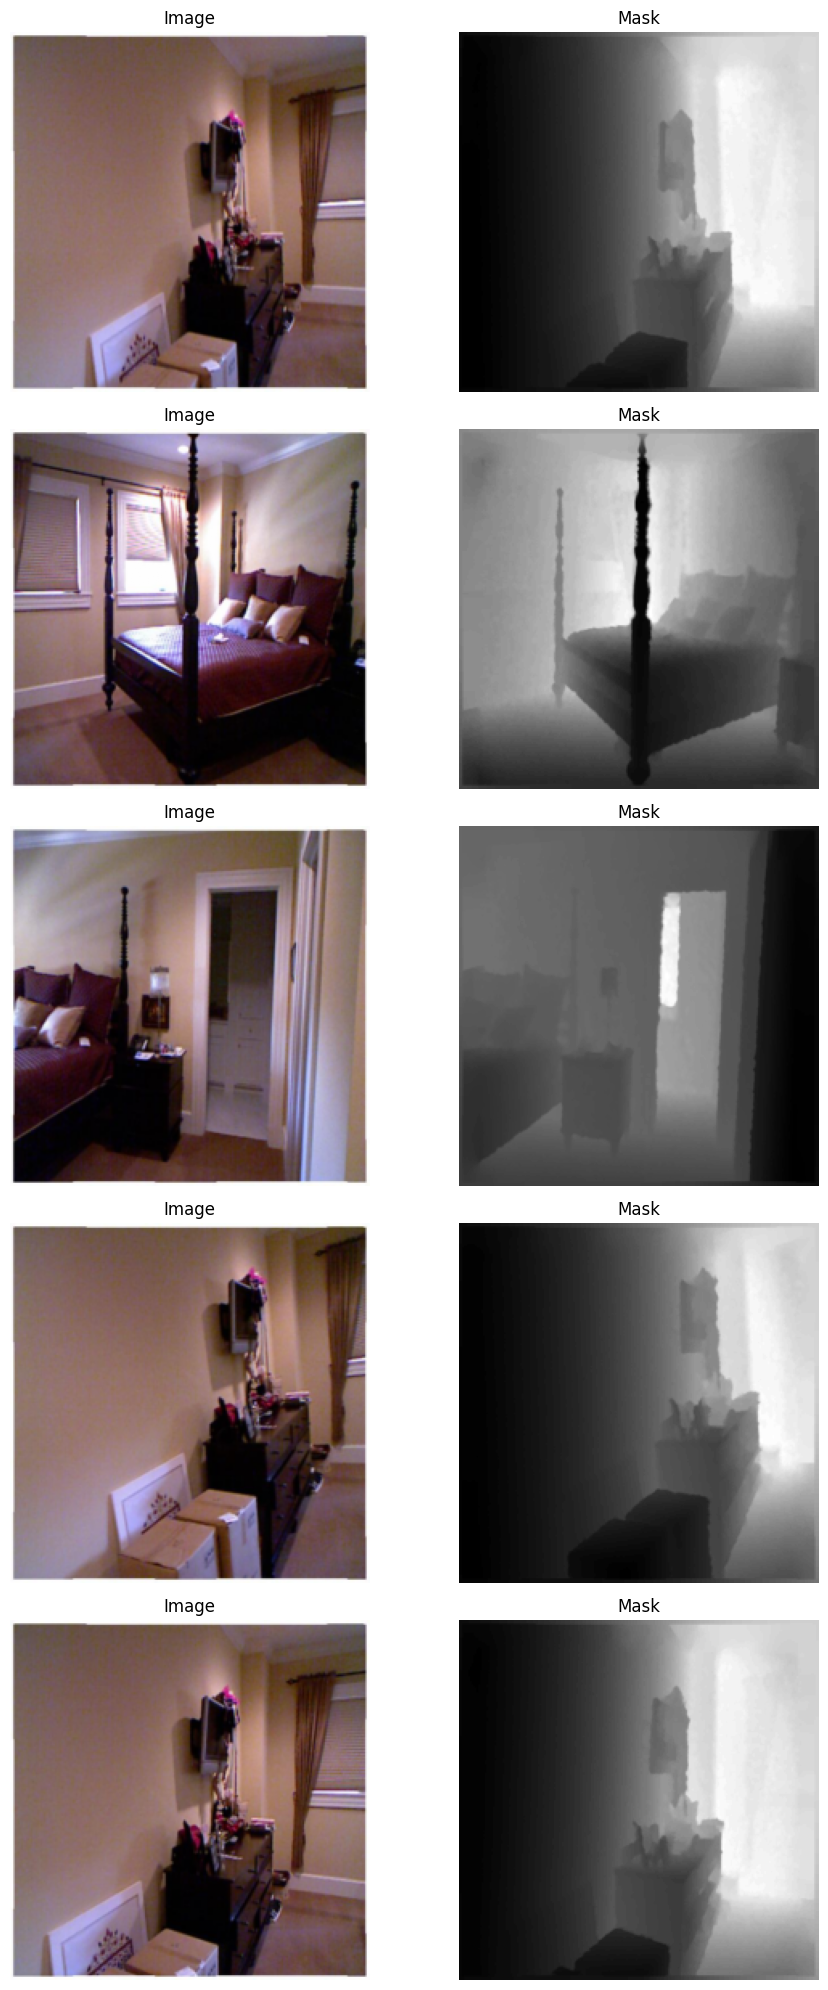

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    image, mask = train_dataset[i]
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, cmap='gray')

    ax[i, 0].set_title('Image')
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
memory_bank = []
model = model.to(device)
# Process each image in the image list
for image, label in tqdm(subset_loader_train, desc="Populate memory bank"):
    # Process the image and label
    local_labels = average_labels(label.squeeze())
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state


    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[:,1:, :]

    # L2-normalize the feature vector
    patch_features = features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    for i in range(patch_features.size(0)):  # Iterate over batch
        # Get the features and labels for the i-th item in the batch
        patch_features = patch_features.cpu()
        features = patch_features[i]
        labels = local_labels[i]

        # Extend the memory bank with the features and labels
        # Here we convert them to CPU tensors and detach from the graph
        memory_bank.append((features.detach(), labels))

Populate memory bank: 100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


In [ ]:
keys = np.array([tup[0].numpy() for tup in memory_bank]) # (number of samples * number of patches) * dim size
labels = np.array([tup[1] for tup in memory_bank])

keys = keys.reshape(-1,keys.shape[2])
labels = labels.reshape(-1)

In [ ]:
print(keys.shape)

(784000, 768)


In [ ]:
del model
del processor
del inputs
del memory_bank
torch.cuda.empty_cache()
import gc
# Run garbage collection
gc.collect()

4260

In [ ]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
searcher = scann.scann_ops_pybind.builder(keys, 150, "dot_product").tree(
    num_leaves=512, num_leaves_to_search=256, training_sample_size=250000).score_ah(
    4, anisotropic_quantization_threshold=0.2).reorder(1800).build()

In [ ]:
beta = .1

for image, label in subset_loader_test:
    # Process the image and label
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    model.to(device)
    model.eval()
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #Squeeze the batch dimension out
    last_hidden_states = last_hidden_states.squeeze(0)
    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[1:, :]
    #patch features [784 x 768] keys
    patch_features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    # Perform the search. This will return the indices of the top-k nearest neighbors.
    neighbors, similarity = searcher.search_batched(patch_features.cpu().detach())

    similarity = (1/beta)*similarity
    similarity = torch.tensor(similarity)
    similarity  = F.softmax(similarity, dim=1)


    neighbor_labels = labels[neighbors]

    weighted_labels = similarity * neighbor_labels.astype(np.float32)
    local_predictions = torch.sum(weighted_labels, dim=1)
    # print(local_predictions.int())
    # print(label[0])

    local_predictions_reshaped = local_predictions.reshape((14,14))
    local_predictions_reshaped = torch.round(local_predictions_reshaped).to(torch.uint8)
    local_predictions_reshaped = local_predictions_reshaped.unsqueeze(0).unsqueeze(0)
    # Upsample the downsampled predictions to the original image size
    local_predictions_reshaped = F.interpolate(local_predictions_reshaped, size=(224, 224), mode='bilinear', align_corners=False)
    pred = np.array(local_predictions_reshaped.squeeze())


    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    # Display images
    axes[0].imshow(pred, cmap='gray')
    axes[0].set_title('prediction')
    axes[0].axis('off')

    axes[1].imshow(label.squeeze(), cmap='gray')
    axes[1].set_title('ground truth')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualisations VOC dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_color_map(num_classes):
    np.random.seed(0)  # For reproducible colors
    color_map = {0: [0, 0, 0]}
    for i in range(1, num_classes):
        color_map[i] = np.random.choice(range(256), size=3).tolist()
    return color_map

def class_to_color(class_id, color_map):
    return color_map.get(class_id, [0, 0, 0])  # Default to black for unknown classes

def visualize_tensor(tensor, color_map):
    image = np.zeros((tensor.shape[1], tensor.shape[2], 3), dtype=np.uint8)
    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[2]):
            image[i, j, :] = class_to_color(tensor[:, i, j].item(), color_map)
    plt.imshow(image)
    plt.show()


In [ ]:
color_map = generate_color_map(21)

In [ ]:
label_hats = torch.load("/content/drive/MyDrive/DINOHBIRD/predictions_noaug.pt")
labels = torch.load("/content/drive/MyDrive/DINOHBIRD/ground_truths_5.pt")

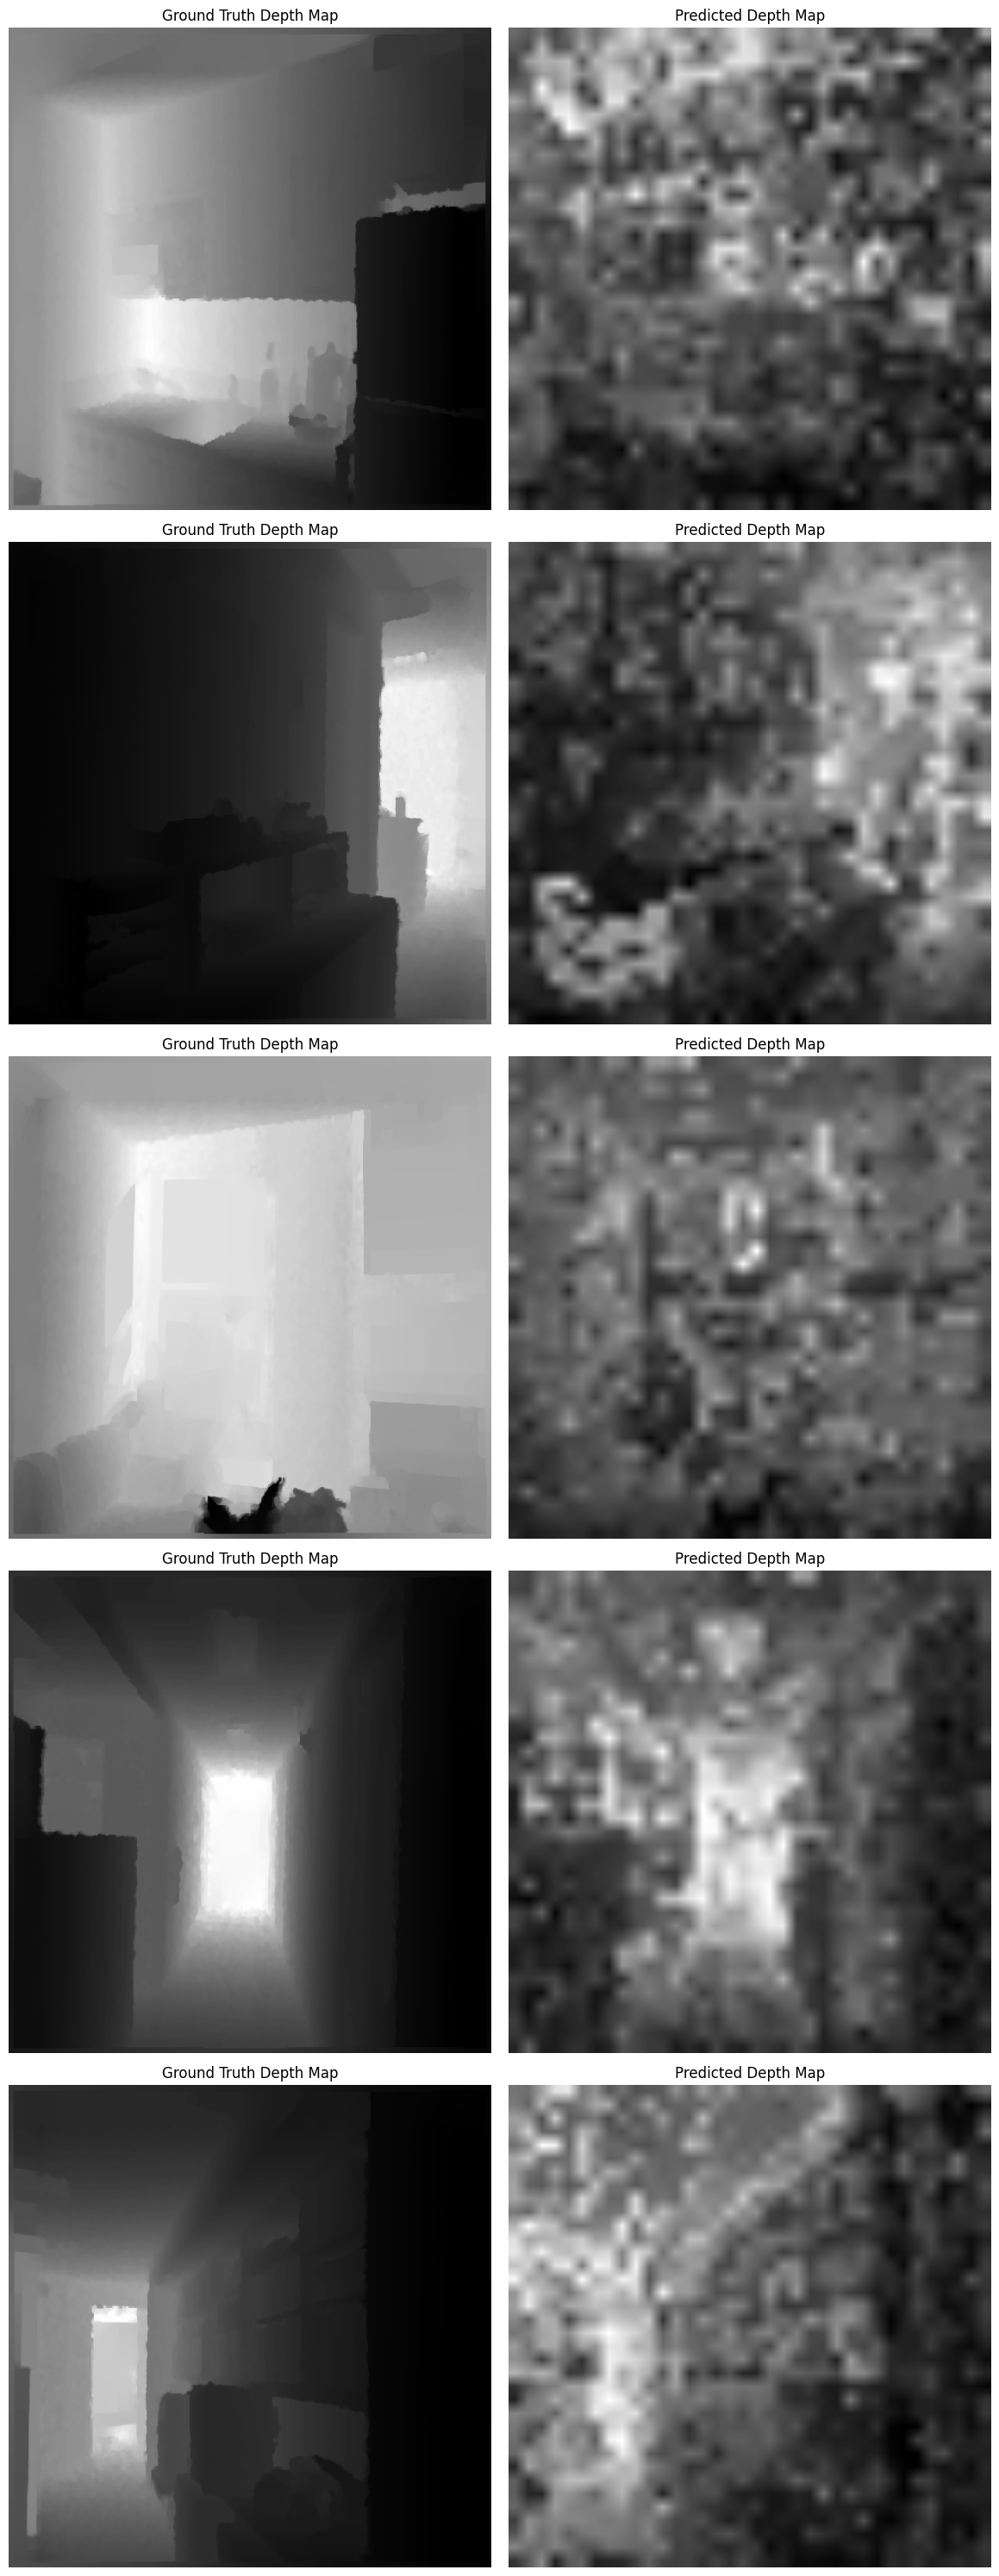

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(12, 5*6))

for i in range(0,5):
  # Visualize the first ground truth depth map
  axes[i,0].imshow(labels[i].squeeze(), cmap='gray')
  axes[i,0].set_title('Ground Truth Depth Map')
  axes[i,0].axis('off')

  # Visualize the first predicted depth map
  axes[i,1].imshow(label_hats[i].squeeze(), cmap='gray')
  axes[i,1].set_title('Predicted Depth Map')
  axes[i,1].axis('off')
plt.tight_layout()

plt.show()

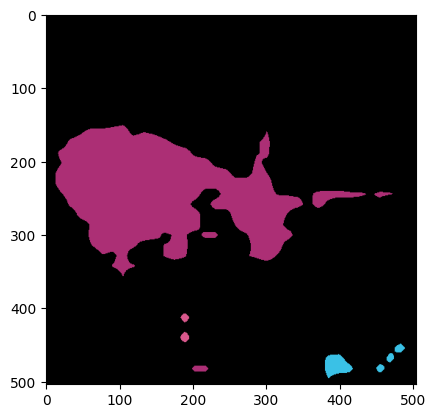

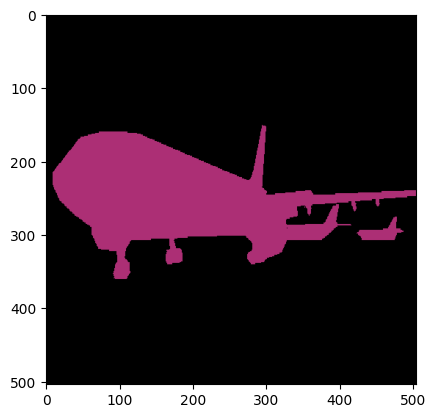

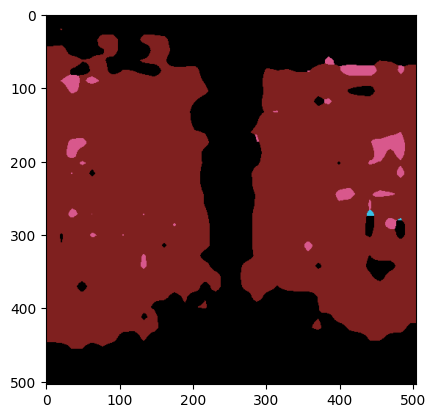

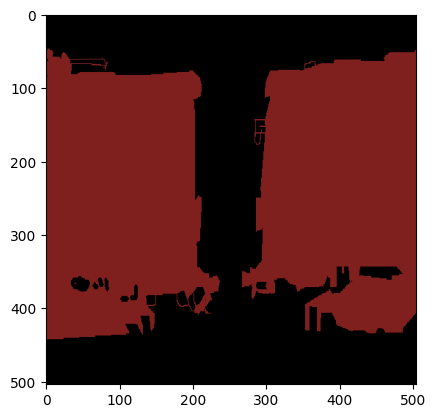

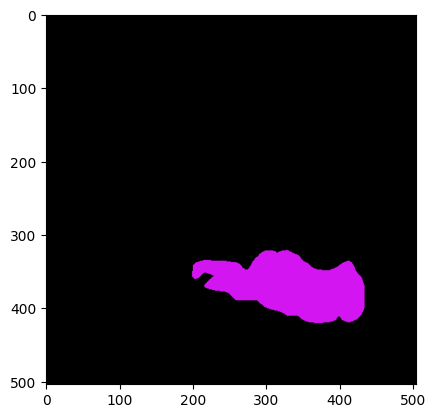

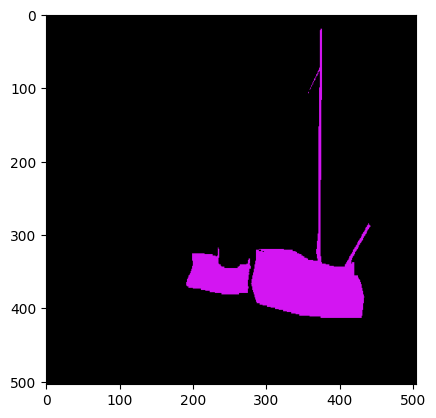

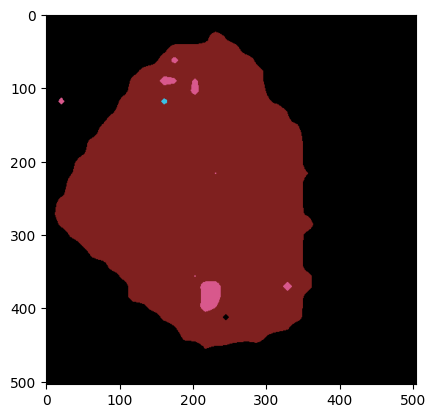

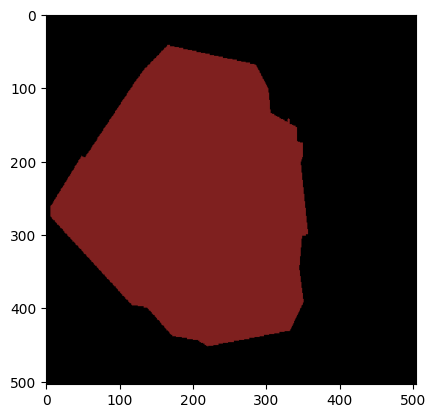

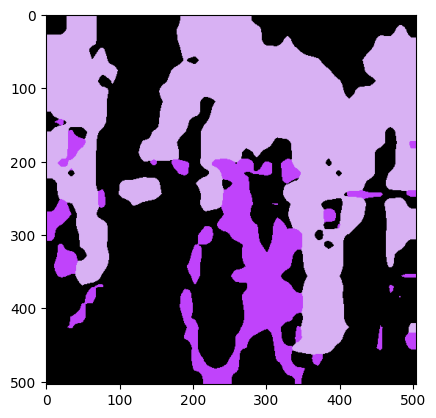

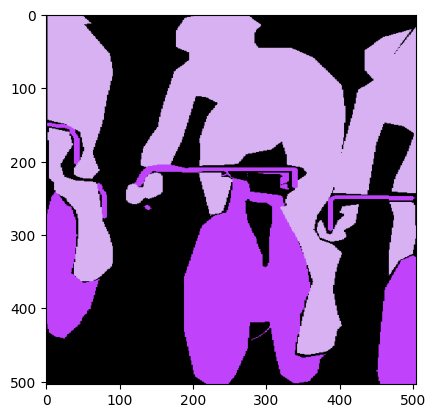

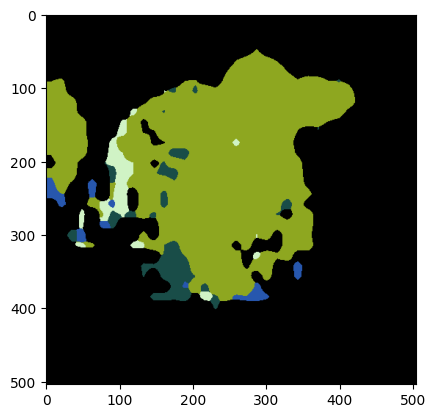

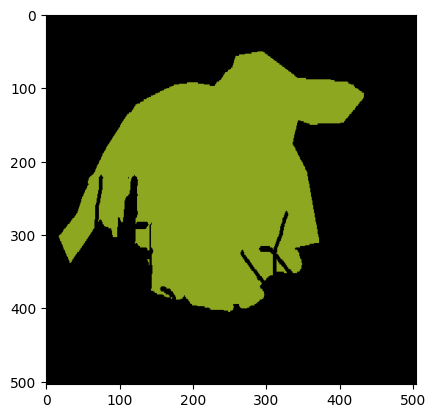

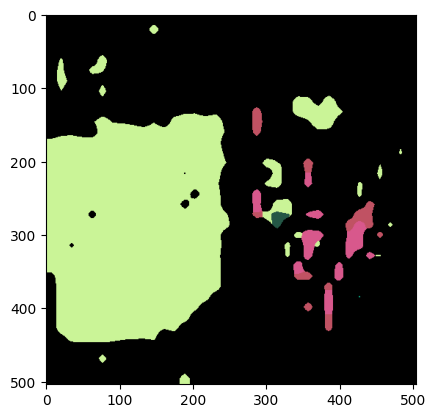

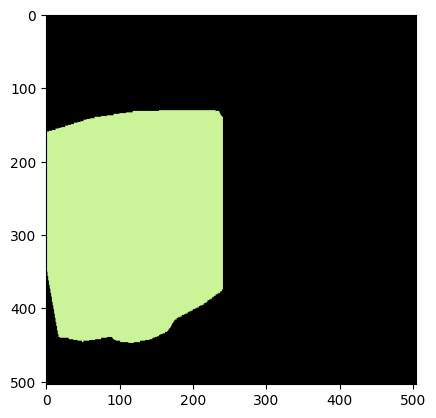

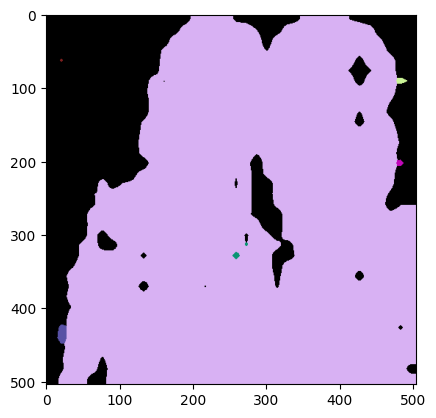

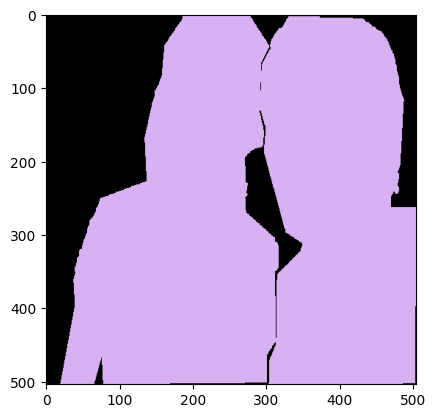

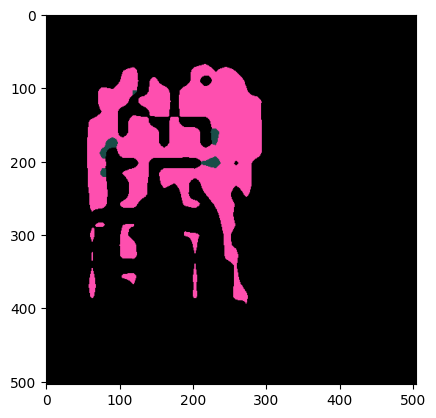

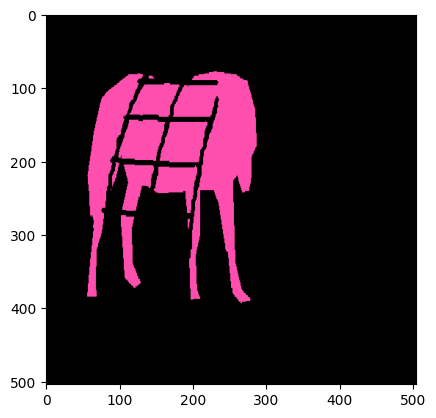

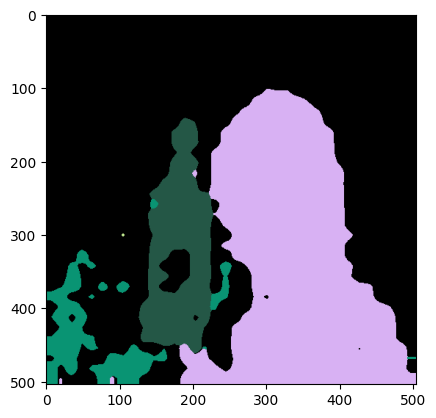

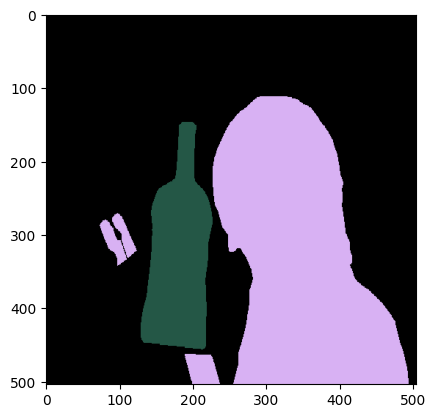

In [ ]:
# label_hats[0].shape
for i in range(0,10):

  visualize_tensor(label_hats[i], color_map)  # To visualize the first predicted image
  visualize_tensor(labels[i], color_map)